# Import Libraries

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string 
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# from keras.models import Sequential
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier


import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import pickle 

In [253]:
import warnings
warnings.filterwarnings('ignore')# Load Data

# Load Data

In [254]:
# read csv file into pandas
df = pd.read_csv("../datasets/question5.csv")
df.head(3)

,question_id,answer,grade
0,5,الموحدون سلالة حكمت المغرب بعد المرابطين ويعتق...,2
1,5,اصلهم من تافيلالت,0
2,5,حركة تحت على الجهاد ضد الحكام الضالمين و التحر...,2


# EDA

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  134 non-null    int64 
 1   answer       134 non-null    object
 2   grade        134 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.3+ KB


In [256]:
df.groupby('grade').size()

grade
0    43
1    39
2    52
dtype: int64

In [257]:
df.duplicated().sum()

5

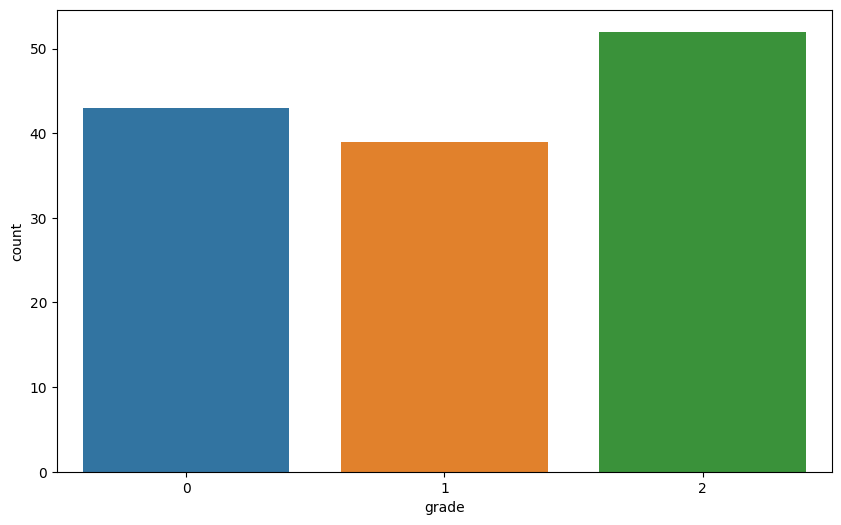

In [258]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='grade')
plt.show()# Data Cleaning

# Data Cleaning

In [259]:
df.drop('question_id', axis=1, inplace=True)

In [260]:
df.dropna(inplace=True)

In [261]:
df.drop_duplicates(inplace=True)

# Data Pre-Preocessing

In [262]:
def txt_preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    #tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

In [263]:
df['tokens'] = df['answer'].apply(txt_preprocess)

# Text Representation

In [264]:
model_word2vec = Word2Vec(df['tokens'], vector_size=100, window=15, min_count=1, workers=4)

In [265]:
def get_word_vector(tokens, model_word2vec):
    textvector = np.zeros((100,), dtype='float32')
    for token in tokens:
        try:
            textvector += model_word2vec.wv[token]
        except KeyError:
            continue
    return textvector


df['textvector'] = df['tokens'].apply(lambda x: get_word_vector(x, model_word2vec))

In [266]:
df.head()

,answer,grade,tokens,textvector
0,الموحدون سلالة حكمت المغرب بعد المرابطين ويعتق...,2,"[الموحدون, سلالة, حكمت, المغرب, بعد, المرابطين...","[-0.06976891, 0.002785156, -0.051945962, -0.01..."
1,اصلهم من تافيلالت,0,"[اصلهم, من, تافيلالت]","[-0.023190495, 0.029899312, -0.008531466, -0.0..."
2,حركة تحت على الجهاد ضد الحكام الضالمين و التحر...,2,"[حركة, تحت, على, الجهاد, ضد, الحكام, الضالمين,...","[-0.047242764, 0.022481509, -0.020809293, 0.00..."
3,الموحدون المغاربة هم حركة سياسية نشأت في المغر...,0,"[الموحدون, المغاربة, هم, حركة, سياسية, نشأت, ف...","[-0.016763823, 0.034114722, -0.018048776, 0.02..."
4,حكمت سلالة الموحدون الأمازيغية البربرية في شما...,2,"[حكمت, سلالة, الموحدون, الأمازيغية, البربرية, ...","[-0.0035503684, 0.03011814, 0.0046652686, 0.03..."


# split the data

In [267]:
train_data = df.sample(frac=0.85, random_state=42)
test_data = df.drop(train_data.index)

In [268]:
X_train = np.array(train_data['textvector'].tolist())
Y_train = np.array(train_data['grade'])

X_test = np.array(test_data['textvector'].tolist())
Y_test = np.array(test_data['grade'])
print(X_test)

[[-4.72427644e-02  2.24815086e-02 -2.08092928e-02 ... -3.47593278e-02
  -3.02105537e-03 -3.08350194e-04]
 [-2.50880122e-02  6.31795004e-02  1.98616609e-02 ... -5.35540618e-02
   8.04384146e-03 -2.70912424e-05]
 [-2.66093984e-02  5.14525063e-02  4.32603620e-03 ... -7.27294311e-02
   1.32054491e-02  1.76451076e-03]
 ...
 [-2.86212713e-02  7.09957108e-02  2.52510589e-02 ... -8.32557976e-02
   1.88412890e-02 -1.26795294e-02]
 [-2.13427916e-02  4.73470651e-02 -4.42620888e-02 ... -2.48031951e-02
   1.19238785e-02  3.60614210e-02]
 [-1.14413975e-02  1.63379796e-02 -5.63307200e-03 ... -3.35679241e-02
  -7.39462767e-03 -2.80180085e-03]]


# build Models 

In [269]:
def getModel(name):
    if name == 'svm_linear':
        model_svm_linear = SVC(kernel='linear' ,probability=True)
        model_svm_linear.fit(X_train, Y_train)
        return model_svm_linear
    elif name == 'svm_rbf':
        model_svm_rbf = SVC(kernel='rbf' , probability=True)
        model_svm_rbf.fit(X_train, Y_train)
        return model_svm_rbf
    elif name == 'random_forest':
        model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
        model_rf.fit(X_train, Y_train)
        return model_rf
    elif name == 'knn':
        model_knn = KNeighborsClassifier(n_neighbors=3)
        model_knn.fit(X_train, Y_train)
        return model_knn
    elif name == 'naive_bayes':
        model_nb = GaussianNB()
        model_nb.fit(X_train, Y_train)
        return model_nb
    elif name == 'bagging':
        # Créer le modèle de base
        base_model = KNeighborsClassifier(n_neighbors=3)
        model_bagging = BaggingClassifier(base_estimator=base_model, n_estimators=10, random_state=42)
        # Entraîner le modèle Bagging
        model_bagging.fit(X_train, Y_train)
        return model_bagging
    elif name == 'ann':
        # MLP: création + entrainement
        model_ANN = MLPClassifier(hidden_layer_sizes=(15, 10), random_state=1, max_iter=800)
        model_ANN.fit(X_train , Y_train)
        return model_ANN
    else:
        raise ValueError("Invalid model name. Please choose from 'svm', 'random_forest', 'knn', or 'naive_bayes'.")


In [270]:
# construire le model 
model_svm_lin = getModel('svm_linear')
# predire les donnees de Test
Y_pred_svm_lin = model_svm_lin.predict_proba(X_test)

In [271]:
# construire le model 
model_svm_rbf = getModel('svm_rbf')
# predire les donnees de Test
Y_pred_svm_rbf = model_svm_rbf.predict_proba(X_test)

In [272]:
# construire le model 
model_rf = getModel('random_forest')
# predire les donnees de Test
Y_pred_rf = model_rf.predict_proba(X_test)

In [273]:
# construire le model 
model_knn = getModel('knn')
# predire les donnees de Test
Y_pred_knn = model_knn.predict_proba(X_test)

In [274]:
# construire le model 
model_nb = getModel('naive_bayes')
# predire les donnees de Test
Y_pred_nb = model_nb.predict_proba(X_test)

In [275]:
# construire le model 
model_ann = getModel("ann")
# predire les donnees de Test
Y_pred_ann = model_ann.predict_proba(X_test)

In [276]:
# construire le model 
model_bagging  = getModel('bagging')
# predire les donnees de Test
Y_pred_bagging = model_bagging.predict_proba(X_test)

# Models Evaluation

In [277]:
models = [
  getModel('svm_linear'),
  getModel('svm_rbf'),
  getModel('random_forest'),
  getModel('knn'),
  getModel('naive_bayes'),
  getModel("ann"),
  getModel('bagging')
]
models_names = [
    'SVM Linear',
    'SVM RBF',
    'Random Forest',
    'KNN',
    'Naive Bayes',
    'ANN',
    'Ensemble Learning (Bagging)'
]
predicted_Xtest_proba = [
    Y_pred_svm_lin,
    Y_pred_svm_rbf,
    Y_pred_rf,
    Y_pred_knn,
    Y_pred_nb,
    Y_pred_ann,
    Y_pred_bagging
]

In [278]:
def getAccuracy(models):
  accuracies = []
  for model in models:
    Y_Test_predi = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_Test_predi)
    accuracies.append(accuracy)

  return accuracies

In [279]:
accuracies = getAccuracy(models)
i=0
for model in models_names:
    print(f"accuracy {model} :  {accuracies[i]}")
    i += 1

accuracy SVM Linear :  0.5263157894736842
accuracy SVM RBF :  0.5263157894736842
accuracy Random Forest :  0.5263157894736842
accuracy KNN :  0.5263157894736842
accuracy Naive Bayes :  0.5263157894736842
accuracy ANN :  0.7368421052631579
accuracy Ensemble Learning (Bagging) :  0.5263157894736842


In [280]:
i=0
for  Y_test_pred_prob in predicted_Xtest_proba:
#     Y_test_pred = Y_test_pred.reshape(-1, 1)
    auc_roc = roc_auc_score(Y_test, Y_test_pred_prob , multi_class='ovr')
    print(f"{models_names[i]}  Aire sous la courbe ROC:", auc_roc)
    i += 1

SVM Linear  Aire sous la courbe ROC: 0.6833694083694084
SVM RBF  Aire sous la courbe ROC: 0.6295454545454545
Random Forest  Aire sous la courbe ROC: 0.7142676767676767
KNN  Aire sous la courbe ROC: 0.6690295815295816
Naive Bayes  Aire sous la courbe ROC: 0.6937950937950937
ANN  Aire sous la courbe ROC: 0.7922799422799423
Ensemble Learning (Bagging)  Aire sous la courbe ROC: 0.720851370851371


# the best Model

In [281]:
max_index = np.argmax(accuracies)
best_model = models[max_index]

In [282]:
pd.DataFrame({"Real ": Y_test , "Predicted" : best_model.predict(X_test)})

,Real,Predicted
0,2,1
1,0,0
2,0,2
3,2,2
4,0,0
5,0,0
6,1,1
7,2,2
8,1,1
9,2,1


# saving the best model

In [65]:
model_path = '../saved_models/model_question5.h5'
with open(model_path, 'wb') as file:
    pickle.dump((best_model, model_word2vec), file)

# Test Model

In [294]:
answer = 'الموحدون هي سلالة بربرية أمازيغيا '
process = txt_preprocess(answer)
txt = get_word_vector(process, model_word2vec)
txt = txt.reshape(1, -1)

i=0
for model in models_names:
    predicted_ques = models[i].predict(txt)[0]
    print(f" {model} :  {predicted_ques}")
    i += 1

 SVM Linear :  0
 SVM RBF :  0
 Random Forest :  1
 KNN :  0
 Naive Bayes :  0
 ANN :  1
 Ensemble Learning (Bagging) :  0
